## Imports

In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from re import search
import matplotlib.pyplot as plt
from mlp_helper import mlp_train
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from sklearn import preprocessing

## Helper functions

In [4]:
def get_subdirectories(folder_path):
    subdirectories = []
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path):
            subdirectories.append(item)
    return subdirectories

def get_files_in_subdirectories(folder_path, file_extension='', file_contains=''):
    files = []
    for root, directories, filenames in os.walk(folder_path):
        for filename in filenames:
            if file_extension == '' and file_contains == '':
                files.append(os.path.join(root, filename))
            elif file_extension != '' and file_contains == '':
                if filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
            elif file_extension == '' and file_contains != '':
                if file_contains in filename:
                    files.append(os.path.join(root, filename))
            else:
                if file_contains in filename and filename.endswith(file_extension):
                    files.append(os.path.join(root, filename))
    return files

def get_num(text):
    if isinstance(text, list):
        numbers = []
        for item in text:
            number_str = search(r'\d+(?=[^\d]*\.csv)', str(item))[0]
            if number_str:
                numbers.append(number_str)
        return numbers
    else:
        number_str = search(r'\d+(?=[^\d]*\.csv)', str(text))[0]
        return number_str if number_str else None

def read_csv_to_tensor(file_path, tensor_name, tensors_dict):
    # Read CSV file as a pandas DataFrame
    dataframe = pd.read_csv(file_path)

    # Convert DataFrame to a tensor
    tensor = torch.tensor(dataframe.values)

    # Store the tensor in the dictionary with the specified variable name
    tensors_dict[tensor_name] = tensor

def read_csv_to_tensor2(file_path):#, tensor_name, tensors_dict):
    # Read CSV file as a pandas DataFrame
    return pd.read_csv(file_path)

def get_data_into_tensor(path,extensions,labels):
    subdirectories = get_subdirectories(path)

    file_extension = extensions
    label = labels

    tensors = {}

    for i in subdirectories:
        folder_i = path+i
        files_t = get_files_in_subdirectories(folder_i)
        files_n = list(dict.fromkeys(get_num(files_t)))
        for index_j,j in enumerate(files_n):
            name_variable = i+'_'+str(index_j)
            for index_k,k in enumerate(file_extension):
                files = get_files_in_subdirectories(folder_i,file_extension=k,file_contains=j)
                # print(files)
                name_variableR = i+'_'+j+'_'+label[index_k]
                # print(f'variable: {name_variableR} person: {i} file_extension: {k} file_path: {files}')
                if index_k == 0:
                    main_df = read_csv_to_tensor2(files[0])#,name_variable,tensors)
                else:
                    label_df = pd.read_csv(files[0],names = ['start','end'])
                    index_start = sorted(label_df.start.tolist())
                    index_end = sorted(label_df.end.tolist())
                    # print(f'label df:\n{label_df}')
                    # print(f'index_start:\n{index_start}')
                    # print(f'index_end:\n{index_end}')
            # Add a new column with a specific value for the matching row indexes
            main_df['label1'] = main_df.apply(lambda row: 'start' if row.name in index_start else '', axis=1)
            main_df['label2'] = main_df.apply(lambda row: 'end' if row.name in index_end else '', axis=1)

            # pd.set_option('display.max_rows', None)
            # print(label_df)
            # print(main_df.iloc[1067:1228])
            # pd.set_option('display.max_rows', 10)
            # print(f'main df:\n{main_df}')

            # Define the condition for the new column
            condition1 = main_df['label1'] == 'start'
            condition2 = main_df['label2'] == 'end'
            # Assign values based on the condition using np.where()
            main_df['label'] = np.where(condition1,1,
                                    np.where(condition2,2,0))
            main_df = main_df.drop(['label1', 'label2'], axis=1)
            
    
            steps1=[]
            steps2=[]
            step = False
            for index, row in main_df.iterrows():
                if row['label'] == 1:
                    step = not step  # Toggle the value of 'step'
                if step:
                    steps1.append(index)
                else:
                    steps2.append(index)
            
            main_df['label'] = main_df.apply(lambda row: 1 if row.name in steps1 else 0, axis=1)
            # Convert DataFrame to a tensor
            tensor = torch.tensor(main_df.values)
            # Store the tensor in the dictionary with the specified variable name
            tensors[name_variable] = tensor

    # Labels are:
    # 0 - Neither start nor end
    # 1 - Start
    # 2 - End

    # Loop through the dictionary
    tensor_unified = torch.Tensor()
    for key, value in tensors.items():
        tensor_unified = torch.cat([tensor_unified,value])

    return tensor_unified

# Custom dataset class
class MyDataset(Dataset):
    def __init__(self, data, time_steps):
        self.dataX = data[:][0]
        self.dataY = data[:][1]
        self.time_steps = time_steps

    def __len__(self):
        return len(self.dataX) - self.time_steps + 1

    def __getitem__(self, idx):
        return (self.dataX[idx:idx+self.time_steps],self.dataY[idx:idx+self.time_steps])

# Custom dataset class
class MyDatasetLSTM(Dataset):
    def __init__(self, data, time_steps):
        self.dataX = data[:][0]
        self.dataY = data[:][1]
        self.time_steps = time_steps

    def __len__(self):
        return len(self.dataX) - self.time_steps + 1

    def __getitem__(self, idx):
        return (self.dataX[idx:idx+self.time_steps],torch.mode(self.dataY[idx:idx+self.time_steps])[0])

# Custom dataset class testing
class MyDatasetLSTM_testing(Dataset):
    def __init__(self, data, time_steps):
        self.data = data
        self.time_steps = time_steps

    def __len__(self):
        return len(self.data) - self.time_steps + 1

    def __getitem__(self, idx):
        return self.data[idx:idx+self.time_steps]


## Data reading / importing

In [5]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,0]
labelssteps = tensor_unified[:,7]
print(labelssteps)
labels = labels.long()
labelssteps = labelssteps.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)


In [6]:
# Convert the PyTorch tensor to a NumPy array
numpy_array = labelssteps.numpy()

# Reshape the NumPy array to a single column
reshaped_array = numpy_array.reshape(-1, 1)

# Create a pandas DataFrame from the reshaped array
df = pd.DataFrame(reshaped_array, columns=['Column_Name'])

labels_df_g = df.loc[0:2000]
print(labels_df_g)


      Column_Name
0               0
1               0
2               0
3               0
4               0
...           ...
1996            1
1997            1
1998            1
1999            1
2000            1

[2001 rows x 1 columns]


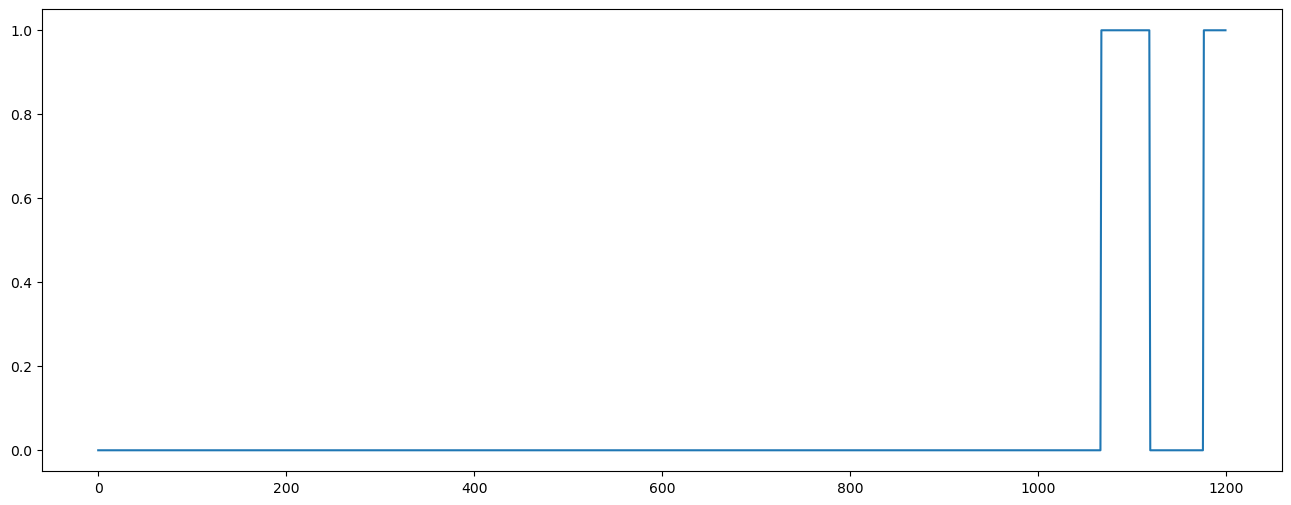

In [9]:
# data_df_g.head
labelssteps2 = labelssteps[0:1200]
fig, (ax) = plt.subplots(1,figsize = (16,6))

# Assuming your columns are named 'col1', 'col2', ..., 'col6'

ax.plot(labelssteps2, label='Activity')


plt.show()


In [13]:
signal_values = labelssteps[5000:200000]

# Example signal values
# signal_values = [0, 1, 1, 0, 0, 1, 1, 0, 0, 1]

# Identify transitions and calculate time differences
transitions = [i for i in range(1, len(signal_values)) if signal_values[i] != signal_values[i-1]]
time_diffs = [transitions[i] - transitions[i-1] for i in range(1, len(transitions))]

# Calculate average period
average_period = sum(time_diffs) / len(time_diffs)

# Calculate average up and down time
average_up_time = sum(time_diffs[::2]) / (len(time_diffs) // 2)
average_down_time = sum(time_diffs[1::2]) / (len(time_diffs) // 2)

print("Average period:", average_period)
print("Average up time:", average_up_time)
print("Average down time:", average_down_time)

Average period: 57.796916691372665
Average up time: 58.216488730723604
Average down time: 57.41162514827995


In [6]:
scaler = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scaler.fit_transform(data))
data_scaled = data_scaled.float()

training_data_scaled = [data_scaled,labels]

# print(f'data {data[0:10][:]}')
# print(f'data scaled {data_scaled[0:10][:]}')
# print(scaler.scale_)

# print(data_scaled.dtype)
# print(data_scaled.shape)

feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDatasetLSTM(training_data_scaled,time_steps=40)
train_data_scaled, test_data_scaled = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


## Graphing

In [7]:
labels_df = pd.DataFrame(training_data[1].numpy())
data_df = pd.DataFrame(data_scaled.numpy())

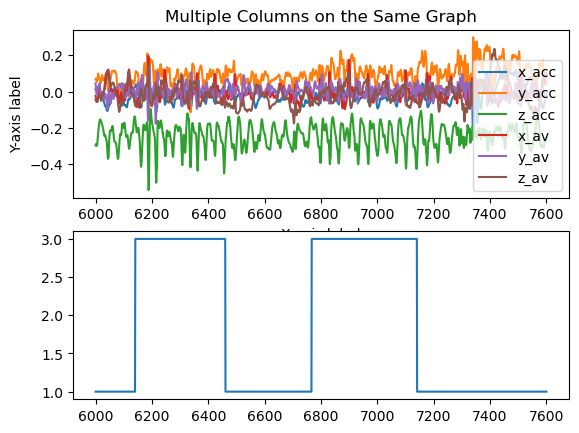

In [8]:

# print(data_df)
size_w = 1600
a_begin = 6000
aend = a_begin+size_w
data_df_g = data_df.loc[a_begin:aend]
labels_df_g = labels_df.loc[a_begin:aend]

# Assuming you have a DataFrame named 'df' and a list of new column names
new_column_names = ['x_acc', 'y_acc', 'z_acc', 'x_av', 'y_av', 'z_av']
new_column_names_labels = ['activity']

# Assign the new column names to the DataFrame
data_df_g.columns = new_column_names
labels_df_g.columns = new_column_names_labels
# data_df_g.head

fig, (ax,ax1) = plt.subplots(2,1)

# Assuming your columns are named 'col1', 'col2', ..., 'col6'
ax.plot(data_df_g['x_acc'], label='x_acc')
ax.plot(data_df_g['y_acc'], label='y_acc')
ax.plot(data_df_g['z_acc'], label='z_acc')
ax.plot(data_df_g['x_av'], label='x_av')
ax.plot(data_df_g['y_av'], label='y_av')
ax.plot(data_df_g['z_av'], label='z_av')

ax.set_xlabel('X-axis label')
ax.set_ylabel('Y-axis label')
ax.set_title('Multiple Columns on the Same Graph')
ax.legend()

ax1.plot(labels_df_g['activity'], label='Activity')

plt.show()


## MLP

1 Iteration - Loss:  {1.107177452112461}


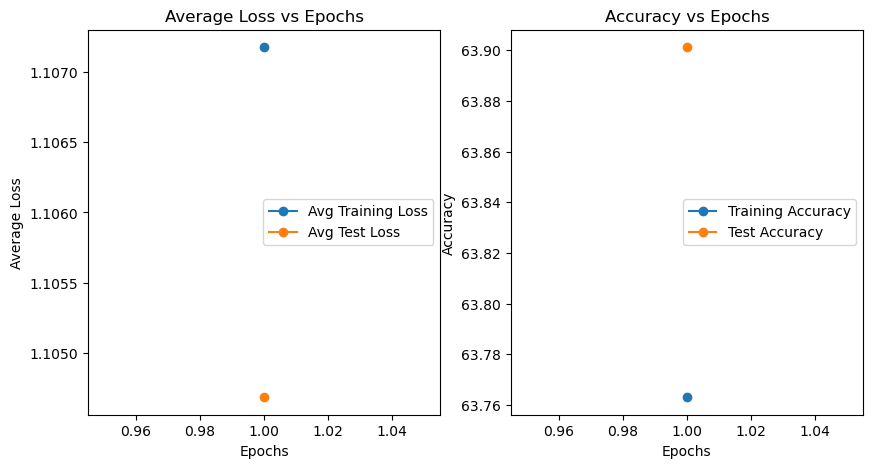

In [56]:
epochs = 1
b_size = 10
hidden_dims = [100,50,10]
lr = 0.005

model,losses,plot = mlp_train(train_data,hidden_dims,epochs,b_size,lr,False,True,feature_dim,class_dim,test_data)

## LSTM for Activity detection

In [67]:
# Example usage
batch_size = 64

dataloader = DataLoader(train_data_scaled, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled, batch_size=batch_size, shuffle=False,drop_last= True)

class LSTMClassifier(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sfm = nn.Softmax(dim = 1)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        #out = self.fc(hn.squeeze(0))
        # print(f'out is now {out.shape}')
        out = out[:, -1, :]
        # print(f'out is now 2 {out.shape}')
        out = self.fc(out)
        # print(f'out is now 3 {out.shape}')
        #out = self.sfm(out)
        # out = torch.argmax(out)
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

print('Preparing datasets')

input_dim = 6
hidden_dim = 100
layer_dim = 1
output_dim = 4

lr = 0.01
n_epochs = 15
# iterations_per_epoch = len(train_dl)
best_acc = 0
patience, trials = 5, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
# sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

print('Start model training')
# print('dataloader', dataloader)
# sequence_length = 10

for epoch in range(1, n_epochs + 1):
    j = 0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        j+=1
        model.train()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch_v.size(0)
        correct += (preds == y_batch_v).sum().item()
    
    acc = correct / total
    print(f'Accuracy epoch {epoch} {acc:2.2%}')
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break


Preparing datasets
Start model training
Accuracy epoch 1 90.39%
Epoch 1 best model saved with accuracy: 90.39%
Accuracy epoch 2 93.42%
Epoch 2 best model saved with accuracy: 93.42%
Accuracy epoch 3 63.87%
Accuracy epoch 4 63.71%
Accuracy epoch 5 63.95%
Epoch:   5. Loss: 1.1587. Acc.: 63.95%
Accuracy epoch 6 63.94%
Accuracy epoch 7 63.30%
Early stopping on epoch 7


## LSTM for Step prediction

In [145]:
folder_path = os.getcwd()+'/data/'
file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']

tensor_unified = get_data_into_tensor(folder_path,file_extension,label)

test_data_path = 'testdata.csv'
dataframe = pd.read_csv(test_data_path)
# Convert DataFrame to a tensor
test_data = torch.tensor(dataframe.values)

data = tensor_unified[:,[0,1,2,3,4,5,6]]
data = data.float()
labels = tensor_unified[:,7]
labels = labels.long()

training_data = [data,labels]

feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension
data_set = TensorDataset(training_data[0],training_data[1])
test_split_per = 0.75
train_size = int(data.size(0)*test_split_per)
test_size = data.size(0) - train_size
train_data, test_data = random_split(data_set, [train_size, test_size])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [146]:
scalerSteps = preprocessing.MaxAbsScaler()
data_scaled = torch.tensor(scalerSteps.fit_transform(data))
data_scaled = data_scaled.float()

training_data_scaled = [data_scaled,labels]

# print(f'data {data[0:10][:]}')
# print(f'data scaled {data_scaled[0:10][:]}')
# print(scaler.scale_)

# print(data_scaled.dtype)
# print(data_scaled.shape)

feature_dim = training_data_scaled[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data_scaled[1]).size(0) # Out Features Dimension
test_split_per = 0.75
train_size = int(data_scaled.size(0)*test_split_per)
test_size = data_scaled.size(0) - train_size
datasetlstm = MyDataset(training_data_scaled,time_steps=40)
train_data_scaled_step, test_data_scaled_step = random_split(datasetlstm, [0.75, 0.25])
feature_dim = training_data[0].size(1) # in Features Dimension
class_dim = torch.unique(training_data[1]).size(0) # Out Features Dimension


In [103]:
class LSTMClassifier_steps(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,dropout_lstm = 0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True,bias = True,dropout = dropout_lstm)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        # out = out[:, :, :]
        out = self.fc(out)
        out = torch.permute(out,[0,2,1])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t for t in (h0, c0)]

In [105]:
dataloader = DataLoader(train_data_scaled_step, batch_size=batch_size, shuffle=True,drop_last= True)
dataloaderValidate = DataLoader(test_data_scaled_step, batch_size=batch_size, shuffle=False,drop_last= True)

print('Preparing datasets')

input_dim = 7
hidden_dim = 120
layer_dim = 1
output_dim = 3

lr = 0.01
n_epochs = 15
best_acc = 0
patience, trials = 8, 0

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)

print('Start model training')

for epoch in range(1, n_epochs + 1):
    j = 0
    for i, (x_batch, y_batch) in enumerate(dataloader):
        j+=1
        model.train()
        # print(f'xbatch_size {x_batch.shape} ybatch_size {y_batch.shape}')
        opt.zero_grad()
        out = model(x_batch)
        # print(f'out_size {out.shape}')
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()

    model.eval()
    correct, total = 0, 0
    for j, (x_batch_v, y_batch_v) in enumerate(dataloaderValidate):
        out = model(x_batch_v)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += (y_batch_v.size(0)*y_batch_v.size(1))
        correct += (preds == y_batch_v).sum().item()
    
    acc = correct / total
    print(f'Accuracy epoch {epoch} {acc:2.2%}')
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best_steps_lstm.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Preparing datasets
Start model training
Accuracy epoch 1 96.82%
Epoch 1 best model saved with accuracy: 96.82%
Accuracy epoch 2 97.06%
Epoch 2 best model saved with accuracy: 97.06%
Accuracy epoch 3 97.08%
Epoch 3 best model saved with accuracy: 97.08%
Accuracy epoch 4 96.45%
Accuracy epoch 5 96.44%
Epoch:   5. Loss: 0.1842. Acc.: 96.44%
Accuracy epoch 6 96.45%
Accuracy epoch 7 96.45%
Accuracy epoch 8 96.45%
Accuracy epoch 9 96.40%
Accuracy epoch 10 96.45%
Epoch:  10. Loss: 0.1622. Acc.: 96.45%
Accuracy epoch 11 96.45%
Early stopping on epoch 11


## Activity prediction

In [125]:
path_activity_model = 'best_activity_lstm.pth'

input_dim = 6
hidden_dim = 100
layer_dim = 1
output_dim = 4

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_activity_model))

test_data = torch.tensor(dataframe.values)
test_data_scaled_act = torch.tensor(scaler.transform(test_data))
test_data_scaled_act = test_data_scaled_act.float()


dataset = MyDatasetLSTM_testing(test_data_scaled_act,time_steps=40)

# # Set the batch size
batch_size = 32

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = []

# Disable gradient calculation
k=0
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:
        
        # Forward pass through the model
        # print(f'size {inputs.shape} dtype {inputs.dtype}')
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        y_pred = pred_probab.argmax(1)
        if(y_pred.shape[0]!= 32):
            print(f'shape {y_pred.shape} k: {k}')
        k+=1
        # print(f"Predicted class: {y_pred}")
        # print(f'shape: {outputs.shape} outputs: {outputs}')
        # break
        # Perform any necessary post-processing on the outputs (e.g., softmax, argmax, etc.)
        # predicted =   # Your post-processing logic here

        # Append the predicted and ground truth labels to the respective lists
        predicted_labels.extend(y_pred)


shape torch.Size([4]) k: 3189


## Step prediction

In [191]:
test_data = torch.tensor(dataframe.values)
zeros_pad = torch.zeros(39)
activity_label = torch.cat((torch.tensor(predicted_labels),zeros_pad),dim=0)
activity_label = activity_label.view(activity_label.shape[0],1)
print(f'act size {activity_label.shape} test size {test_data.shape}')
test_data_w_act = torch.cat((activity_label,test_data),dim=1)
print(f'act size {test_data_w_act.shape}')

test_data_scaled_steps = torch.tensor(scalerSteps.transform(test_data_w_act))
test_data_scaled_steps = test_data_scaled_steps.float()



# print(test_data_w_act.shape)

/var/folders/8g/zrqn7yqx5yvgtqtt793z3p5m0000gn/T/ipykernel_1375/895000160.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  activity_label = torch.cat((torch.tensor(activity_label),zeros_pad),dim=0)


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [193]:
path_steps_model = 'best_steps_lstm.pth'

input_dim = 7
hidden_dim = 120
layer_dim = 1
output_dim = 3

model = LSTMClassifier_steps(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(path_steps_model))


dataset = MyDatasetLSTM_testing(test_data_scaled_steps,time_steps=40)

# # Set the batch size
batch_size = 40

# # Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=batch_size,drop_last= False)

# # Set the model in evaluation mode
model.eval()

# # Initialize lists to store the predicted labels and ground truth labels
predicted_labels = torch.empty((0, 2),dtype=torch.float32)
y=0
# Disable gradient calculation
with torch.no_grad():
    # Iterate over batches in the data loader
    for inputs in data_loader:
        # Forward pass through the model
        # print(f'size {inputs.shape} dtype {inputs.dtype}')
        outputs = model(inputs)
        pred_probab = nn.Softmax(dim=1)(outputs)
        # y_pred = pred_probab.argmax(1)
        mat = pred_probab[0,(1,2),:]
        mat = torch.permute(mat,[1,0])
        if(mat.shape[0]!=40):
            print(y)
            print(mat.shape[0])
        predicted_labels = torch.cat((predicted_labels,mat),dim = 0)
        y+=1
        # print(f"Predicted class: {pred_probab} {pred_probab.shape}")
        # print(f"Result class: {predicted_labels} {predicted_labels.shape}")
        # print(f'shape: {outputs.shape} outputs: {outputs}')
        # Perform any necessary post-processing on the outputs (e.g., softmax, argmax, etc.)
        # predicted =   # Your post-processing logic here

        # Append the predicted and ground truth labels to the respective lists
        # predicted_labels.extend(y_pred)


In [194]:
zeros_pad = torch.zeros((11,2))
predicted_labels = torch.cat((predicted_labels,zeros_pad),dim=0)
print(f"Predicted class: {predicted_labels} {predicted_labels.shape}")


Predicted class: tensor([[5.2765e-04, 2.4150e-04],
        [7.2719e-05, 1.1153e-04],
        [5.0461e-05, 2.3108e-04],
        ...,
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00]]) torch.Size([102091, 2])


In [18]:
from sklearn.ensemble import RandomForestClassifier

X = train_data[:][0]
y = train_data[:][1]
X_test = test_data[:][0]
y_test = test_data[:][1]

clf = RandomForestClassifier(max_depth=4, random_state=0)
clf.fit(X, y)

print("Score with training data: ",round(clf.score(X,y),4))
print("Score with test data: ",round(clf.score(X_test,y_test),4))



Score with training data:  0.7248
Score with test data:  0.7243
R^2 train:  0.6377432021493313
R^2 test:  0.6384752499363395


/Users/rodolfocacacho/opt/anaconda3/envs/python_env_ann/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1 Iteration - Loss:  {0.5871667010535466}
2 Iteration - Loss:  {0.5870351438821999}
3 Iteration - Loss:  {0.5870319525644411}
4 Iteration - Loss:  {0.5870306758748371}
5 Iteration - Loss:  {0.587029990234588}


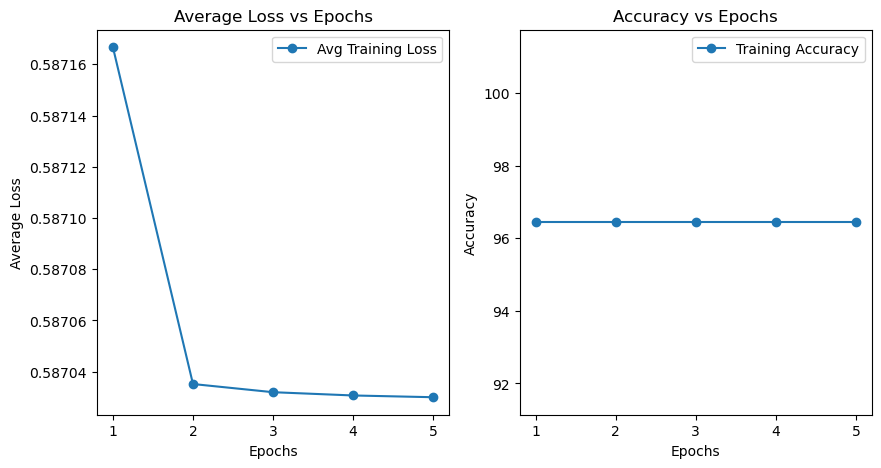

In [3]:
from mlp_helper import mlp_train

train_data = tensor_unified[:, torch.arange(tensor_unified.size(1)) != 0]
train_data = train_data.to(torch.float32)
hidden_dims = [10]
epochs = 5
batch_size = 10
learning_rate = 0.08
cuda = False
plots = True
test_data = test_data.to(torch.float32)

mlp_model, losses,plot = mlp_train(train_data,hidden_dims, epochs, batch_size, learning_rate, cuda, plots,test_data)

In [4]:
with torch.no_grad():
    test_preds = mlp_model(test_data)

In [5]:
test_preds.shape

torch.Size([102091, 3])

In [195]:
# Assuming your tensor is named 'tensor_data'
# Convert the tensor to a NumPy array

# test_preds = test_preds[:, torch.arange(test_preds.size(1)) != 0]
array_data = predicted_labels.numpy()

# Define header names
header_names = ['start', 'end']  # Replace with your actual header names
df = pd.DataFrame(array_data, columns=header_names)  # Replace with your actual column names
df.index.name = 'index'  # Specify the name of the index column

# Save the DataFrame to a CSV file
df.to_csv('data_lstm_40_step_length_mdw.csv')

In [199]:
df.start

index
0         0.000528
1         0.000073
2         0.000050
3         0.000112
4         0.000126
            ...   
102086    0.000000
102087    0.000000
102088    0.000000
102089    0.000000
102090    0.000000
Name: start, Length: 102091, dtype: float32

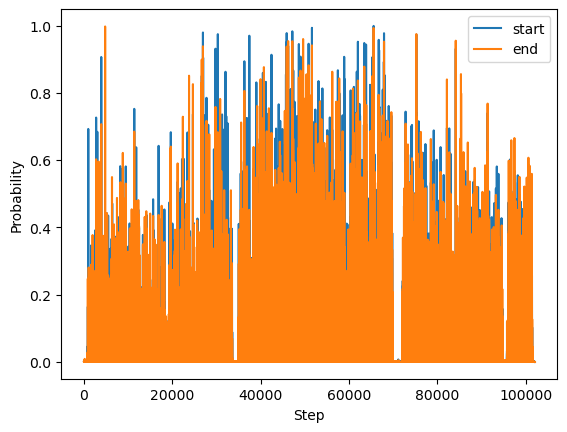

In [200]:
fig, ax = plt.subplots(1)

# Assuming your columns are named 'col1', 'col2', ..., 'col6'
ax.plot(df.start, label='start')
ax.plot(df.end, label='end')

ax.set_xlabel('Step')
ax.set_ylabel('Probability')
ax.legend()


plt.show()

### Test preprocessing


In [ ]:
folder_path = os.getcwd()+'/data/'
print(folder_path)
subdirectories = get_subdirectories(folder_path)
print(subdirectories)

file_extension = ['.csv','.csv.stepMixed']
label = ['data','labels']
tensors = {}

for i in subdirectories:
    folder_i = folder_path+i
    files_t = get_files_in_subdirectories(folder_i)
    files_n = list(dict.fromkeys(get_num(files_t)))
    for index_j,j in enumerate(files_n):
        name_variable = i+'_'+str(index_j)
        for index_k,k in enumerate(file_extension):
            files = get_files_in_subdirectories(folder_i,file_extension=k,file_contains=j)
            name_variableR = i+'_'+j+'_'+label[index_k]
            # print(f'variable: {name_variableR} person: {i} file_extension: {k} file_path: {files}')
            if index_k == 0:
                main_df = read_csv_to_tensor2(files[0])#,name_variable,tensors)
            else:
                label_df = pd.read_csv(files[0],names = ['start','end'])
                label_df['start_end_index'] = label_df['start'] + 10
                label_df['end_start_index'] = label_df['end'] - 10
                index_start = label_df.start.tolist()
                index_start_end = label_df.start_end_index.tolist()
                index_end = label_df.end.tolist()
                index_end_start = label_df.end_start_index.tolist()
                print(index_start_end)
        # Add a new column with a specific value for the matching row indexes
        main_df['label1'] = main_df.apply(lambda row: 'start' if row.name in index_start else '', axis=1)
        # main_df['label1'] = main_df.apply(lambda row: 'start' if (int(row.name) >= int(index_start) and int(row.name) <= int(index_start_end)) else '', axis=1)
        main_df['label2'] = main_df.apply(lambda row: 'end' if (int(row.name) >= int(index_end_start) and int(row.name) <= int(index_end)) else '', axis=1)
        # Define the condition for the new column
        condition1 = main_df['label1'] == 'start'
        condition2 = main_df['label2'] == 'end'
        # Assign values based on the condition using np.where()
        main_df['label'] = np.where(condition1,1,
                                np.where(condition2,2,0))
        main_df = main_df.drop(['label1', 'label2'], axis=1)
        # print(main_df)
        # Convert DataFrame to a tensor
        tensor = torch.tensor(main_df.values)
        # Store the tensor in the dictionary with the specified variable name
        tensors[name_variable] = tensor

# Labels are:
# 0 - Neither start nor end
# 1 - Start
# 2 - End